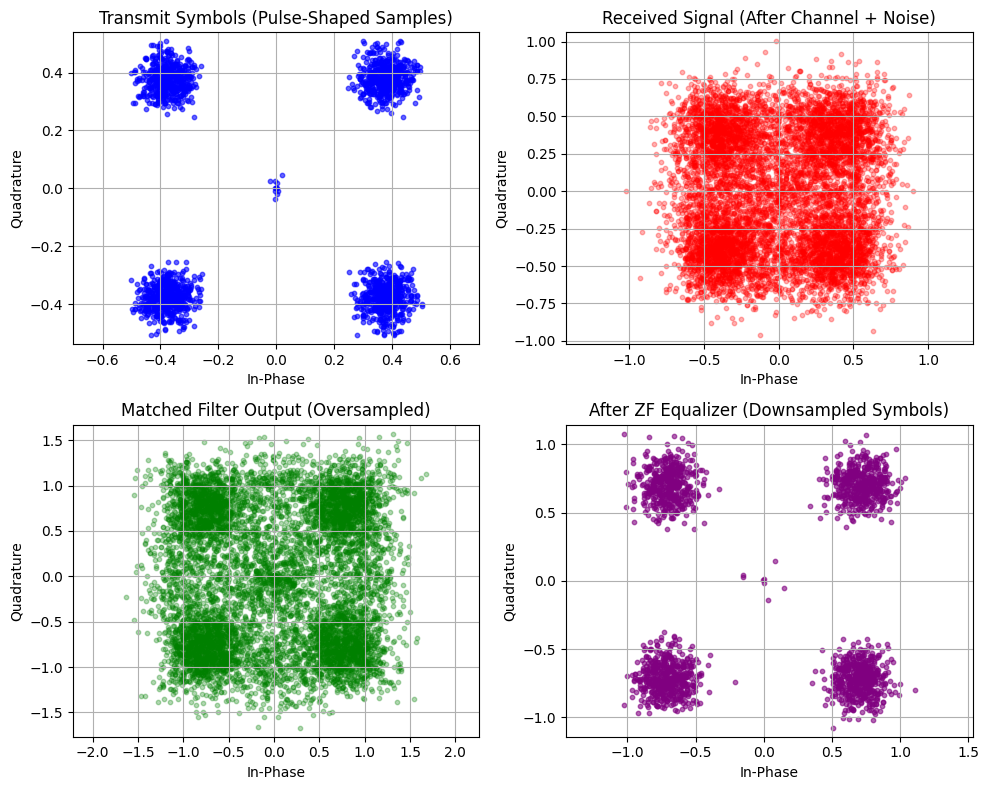

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

###############################################################################
# 1) HELPER FUNCTIONS
###############################################################################

def rrc_filter(beta, span, sps):
    """
    Generate a Root Raised Cosine (RRC) filter impulse response.

    :param beta: Roll-off factor (0 <= beta <= 1).
    :param span: Filter span in symbols.
    :param sps:  Samples per symbol.
    :return:     RRC filter taps as a 1-D numpy array.
    """
    # Filter length
    N = span * sps

    # Time index for filter coefficients
    t = np.arange(-N, N+1) / float(sps)

    # Handle t = 0 case carefully to avoid division by zero
    h = np.zeros_like(t, dtype=float)
    for i, val in enumerate(t):
        if val == 0.0:
            # Special case (limiting form)
            h[i] = 1.0 - beta + 4.0*beta/np.pi
        elif abs(4*beta*val) == 1:
            # Another special case
            h[i] = (beta/np.sqrt(2)) * (
                (1+2/np.pi) * np.sin(np.pi/(4*beta)) +
                (1-2/np.pi) * np.cos(np.pi/(4*beta))
            )
        else:
            # General case
            numerator = np.sin(np.pi*val*(1-beta)) + \
                        4*beta*val*np.cos(np.pi*val*(1+beta))
            denominator = np.pi*val*(1 - (4*beta*val)**2)
            h[i] = numerator / denominator

    # Normalize filter energy
    h = h / np.sqrt(np.sum(h**2))
    return h

def add_awgn_noise(signal, snr_dB):
    """
    Add AWGN noise to the input signal to achieve the specified SNR (dB).

    :param signal: 1-D array of complex samples.
    :param snr_dB: Desired Signal-to-Noise Ratio in dB.
    :return:       Noisy signal (complex).
    """
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr_dB/10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(len(signal)) + 1j*np.random.randn(len(signal)))
    return signal + noise

###############################################################################
# 2) SIMULATION PARAMETERS
###############################################################################

M          = 4          # 4QAM (QPSK)
numSymbols = 2000       # Number of symbols
sps        = 4          # Samples per symbol (oversampling factor)
rolloff    = 0.25       # RRC roll-off factor
span       = 6          # RRC filter span in symbols
snr_dB     = 10         # SNR in dB
# 4-tap channel (complex):
channel_taps = np.array([0.8+0.0j, 0.2+0.0j, 0.1-0.05j, 0.05+0.1j])

###############################################################################
# 3) TRANSMITTER
###############################################################################

# (A) Generate 4QAM (QPSK) symbols
# Each symbol is in {0,1,2,3} -> mapped to QPSK constellation
bits = np.random.randint(0, M, numSymbols)
tx_symbols = np.sqrt(1/2)*( (2*(bits % 2)-1) + 1j*(2*(bits//2)-1) )
#   Explanation:
#   bits % 2 = [0 or 1] -> maps to in-phase
#   bits // 2 = [0 or 1] -> maps to quadrature
#   Multiply by sqrt(1/2) to have unit-average energy

# (B) RRC filter (pulse shaping)
h_rrc = rrc_filter(rolloff, span, sps)

# (C) Upsample and filter
tx_upsampled = np.zeros(numSymbols*sps, dtype=complex)
tx_upsampled[::sps] = tx_symbols  # insert zeros between symbols
tx_shaped = convolve(tx_upsampled, h_rrc, mode='full')

###############################################################################
# 4) CHANNEL AND NOISE
###############################################################################

# (A) Convolve with channel
rx_channel_out = convolve(tx_shaped, channel_taps, mode='full')

# (B) Add AWGN
rx_noisy = add_awgn_noise(rx_channel_out, snr_dB)

###############################################################################
# 5) RECEIVER: MATCHED FILTER
###############################################################################

# Convolve with RRC again (matched filter)
rx_matched = convolve(rx_noisy, h_rrc, mode='full')

###############################################################################
# 6) ZERO-FORCING (ZF) EQUALIZER
###############################################################################

# The channel is known: channel_taps
# The ZF filter is 1 / Channel in the Z-domain. But for simplicity,
# we can do a direct time-domain inverse here if the channel is short.

# Time-domain approach:
# If we assume the channel is short and we want an FIR inverse, we can
# design it by direct deconvolution. Because we have "channel_taps"
# and we want an FIR that convolved with channel_taps -> delta function.

# We'll pick a length for the ZF equalizer (somewhat arbitrary).
# Alternatively, a simpler approach for demonstration is to
# directly "divide" in frequency domain.
# But let's do a quick time-domain approach using np.convolve.

# To avoid complexities of polynomial division, let's do a naive approach
# to keep it instructive and short.

def zero_forcing_time_domain_inverse(h, inv_length=16):
    """
    A naive approach to find a ZF inverse filter in time-domain
    by solving a system of equations:
        h * w = delta
    :param h:            Channel impulse response (1-D).
    :param inv_length:   Desired length of the inverse filter.
    :return:             zf_filter: FIR filter approximating channel inverse.
    """
    # We want to solve h * w = delta(d),
    # e.g. at a chosen delay d in [0..inv_length-1].
    # We'll choose delay = len(h)//2 for simplicity.

    Lh = len(h)
    d = Lh//2  # pick a middle tap as the main path

    # Construct convolution matrix for h
    # Each row is a shifted version of h
    conv_mat = np.zeros((inv_length, inv_length), dtype=complex)
    for row in range(inv_length):
        for col in range(inv_length):
            tap_index = row - col
            if 0 <= tap_index < Lh:
                conv_mat[row, col] = h[tap_index]

    # Desired impulse response
    desired = np.zeros(inv_length, dtype=complex)
    desired[d] = 1.0  # place delta at delay d

    # Solve for w in conv_mat @ w = desired
    w, _, _, _ = np.linalg.lstsq(conv_mat, desired, rcond=None)
    return w

# Design ZF filter
zf_filter_len = 16
zf_filter = zero_forcing_time_domain_inverse(channel_taps, inv_length=zf_filter_len)

# Apply ZF filter
rx_zf = convolve(rx_matched, zf_filter, mode='full')

###############################################################################
# 7) DOWNSAMPLE & SYMBOL ESTIMATION
###############################################################################

# After matched filter and ZF, we expect the main energy
# around some delay offset. We'll guess an appropriate offset:
delay = span + len(channel_taps) + (zf_filter_len//2)

# Downsample at 'sps' starting from 'delay'
rx_zf_downsampled = rx_zf[delay::sps]

# Make sure we only take as many symbols as we sent
rx_zf_downsampled = rx_zf_downsampled[:numSymbols]

###############################################################################
# 8) PLOTTING
###############################################################################

plt.figure(figsize=(10, 8))

# 8.1) Transmitted (Upsampled) constellation
# Only plot the symbol instants for clarity
plt.subplot(2,2,1)
plt.title("Transmit Symbols (Pulse-Shaped Samples)")
idx_sym = np.arange(0, len(tx_shaped), sps)  # symbol indices in shaped signal
plt.scatter(tx_shaped[idx_sym].real, tx_shaped[idx_sym].imag, color='blue', alpha=0.6, s=10)
plt.grid(True)
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")
plt.axis('equal')

# 8.2) Received signal after channel + noise (still oversampled)
plt.subplot(2,2,2)
plt.title("Received Signal (After Channel + Noise)")
plt.scatter(rx_noisy.real, rx_noisy.imag, color='red', alpha=0.3, s=10)
plt.grid(True)
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")
plt.axis('equal')

# 8.3) After Matched Filter (still oversampled)
plt.subplot(2,2,3)
plt.title("Matched Filter Output (Oversampled)")
plt.scatter(rx_matched.real, rx_matched.imag, color='green', alpha=0.3, s=10)
plt.grid(True)
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")
plt.axis('equal')

# 8.4) After ZF Equalizer (Downsampled to symbol rate)
plt.subplot(2,2,4)
plt.title("After ZF Equalizer (Downsampled Symbols)")
plt.scatter(rx_zf_downsampled.real, rx_zf_downsampled.imag, color='purple', alpha=0.6, s=10)
plt.grid(True)
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")
plt.axis('equal')

plt.tight_layout()
plt.show()
